Решение путем внешней агрегации семантики

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_path = "/content/gdrive/My Drive/Models/"

In [ ]:
pip install transformers

     |████████████████████████████████| 1.3MB 9.1MB/s 
     |████████████████████████████████| 1.1MB 23.1MB/s 
     |████████████████████████████████| 2.9MB 15.5MB/s 
     |████████████████████████████████| 890kB 50.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=adcfc76bdc86f14e09f47d5775047d1008a68dc379bb0374bc1386030c3662bb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 41.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 113MB/s]


In [ ]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
df.shape

(15746, 11)

In [ ]:
df.info

<bound method DataFrame.info of                 userName  ...              appId
0          Andrew Thomas  ...          com.anydo
1           Craig Haines  ...          com.anydo
2          steven adkins  ...          com.anydo
3       Lars Panzerbjørn  ...          com.anydo
4          Scott Prewitt  ...          com.anydo
...                  ...  ...                ...
15741          Tammy Kay  ...  com.appxy.planner
15742          Ysm Johan  ...  com.appxy.planner
15743      casey dearden  ...  com.appxy.planner
15744     Jerry G Tamate  ...  com.appxy.planner
15745  Ahmed elsalamouni  ...  com.appxy.planner

[15746 rows x 11 columns]>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 8, 6

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'score')

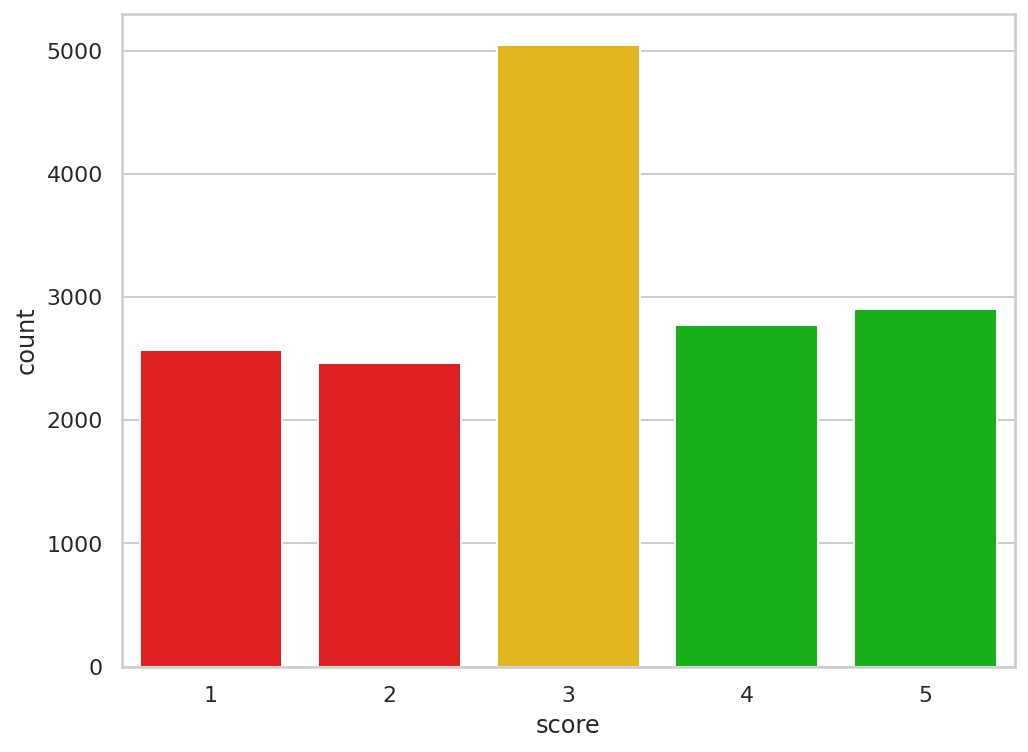

In [ ]:
sns.set(style='whitegrid')
sns.set_palette(sns.color_palette(["#ff0000", "#ff0000", "#ffc800", "#00c800", "#00c800"]))
sns.countplot(df.score)
plt.xlabel('score')

In [ ]:
def scr2snt(scr):
  scr = int(scr)
  if scr <= 2:
    return 0
  elif scr == 3:
    return 1
  else:
    return 2

In [ ]:
df['sentiment'] = df.score.apply(scr2snt)

In [ ]:
tags = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'sentiment')

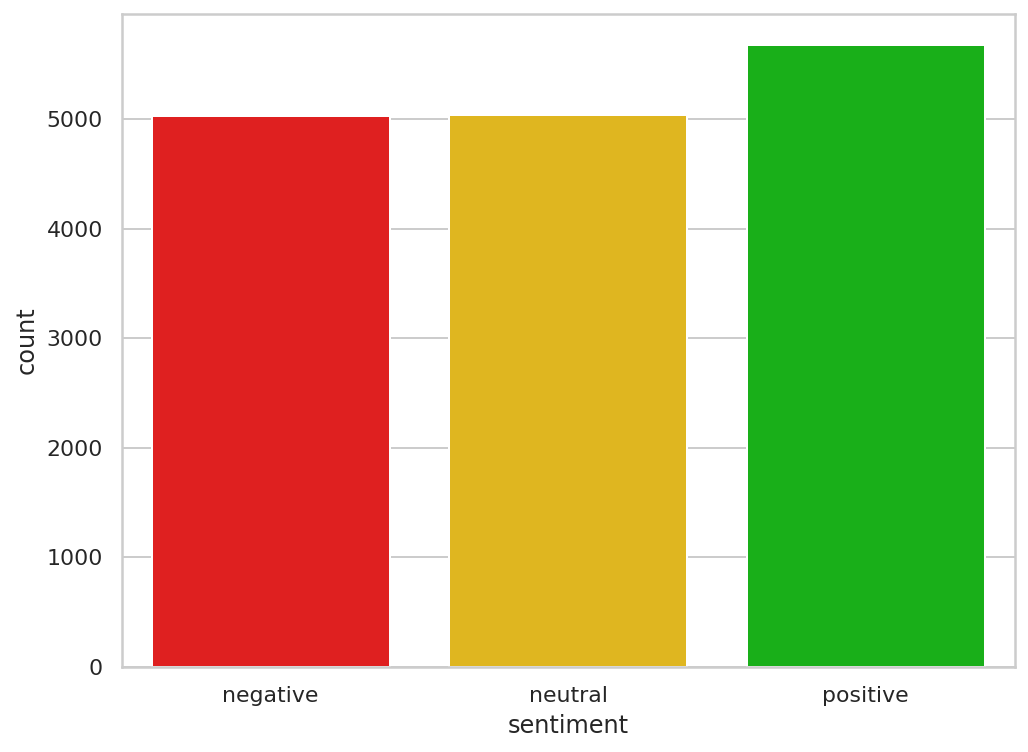

In [ ]:
sns.set_palette(sns.color_palette(["#ff0000", "#ffc800", "#00c800"]))
sns.countplot(df.sentiment).set_xticklabels(tags)
plt.xlabel('sentiment')

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased' 

In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
sent = 'My test sentence for tokenization'
tokens = tokenizer.tokenize(sent)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(tokens)
print(token_ids)

['My', 'test', 'sentence', 'for', 'token', '##ization']
[1422, 2774, 5650, 1111, 22559, 2734]


In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
print(tokenizer.max_model_input_sizes[BERT_MODEL_NAME])

512


In [ ]:
encoder = tokenizer.encode_plus(
  sent, add_special_tokens=True,
  max_length=100,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoder['input_ids'].flatten()

tensor([  101,  1422,  2774,  5650,  1111, 22559,  2734,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
encoder['attention_mask'].flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [ ]:
token_lengths = []
for sent in df.content:
  tokens = tokenizer.encode(sent, max_length=tokenizer.max_model_input_sizes[BERT_MODEL_NAME])
  token_lengths.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

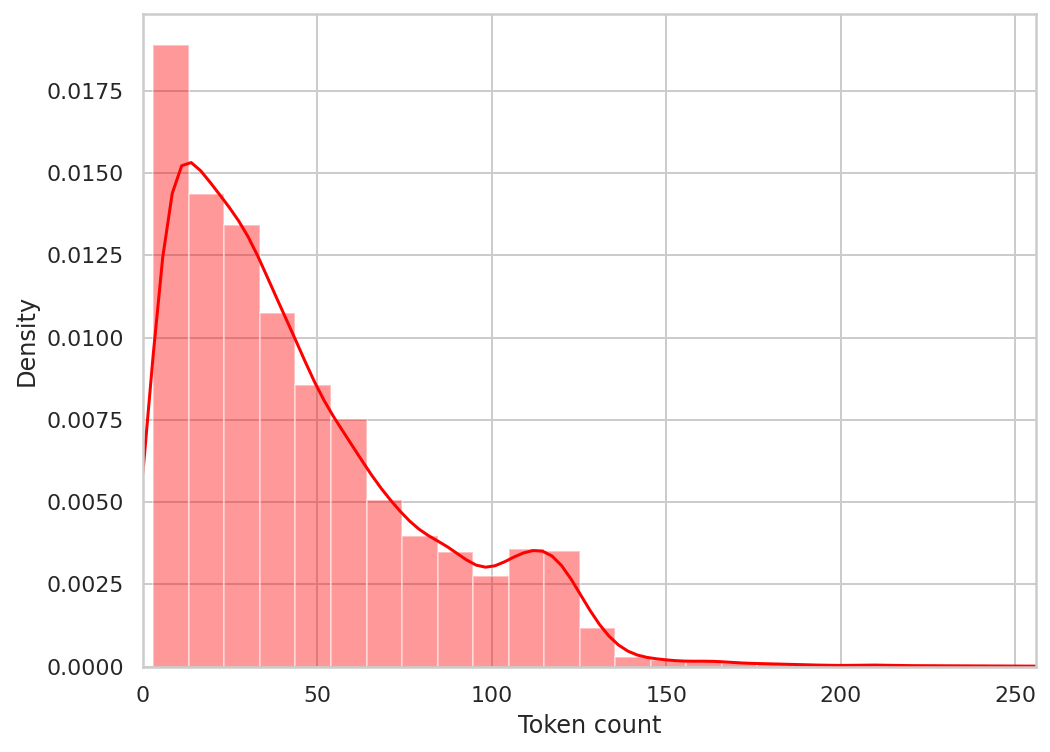

In [ ]:
sns.distplot(token_lengths)
plt.xlim([0, tokenizer.max_model_input_sizes[BERT_MODEL_NAME] // 2])
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 175

In [ ]:
class ReviewsDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, MAX_LEN):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.MAX_LEN = MAX_LEN
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoder = tokenizer.encode_plus(
      review, add_special_tokens=True,
      max_length=self.MAX_LEN,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {'review': review, 'input_ids': encoder['input_ids'].flatten(), 'attention_mask': encoder['attention_mask'].flatten(), 'target': torch.tensor(target, dtype=torch.long)}

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
print(df_train.shape, df_val.shape, df_test.shape)

(14171, 12) (787, 12) (788, 12)


In [ ]:
def get_loader(df, tokenizer, MAX_LEN, BATCH_SIZE):
  data = ReviewsDataset(reviews=df.content.to_numpy(), targets=df.sentiment.to_numpy(), tokenizer=tokenizer, MAX_LEN=MAX_LEN)
  loader = DataLoader(data, batch_size=BATCH_SIZE)
  return loader

In [ ]:
BATCH_SIZE = 16

train_loader = get_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_loader = get_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = get_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['review', 'input_ids', 'attention_mask', 'target'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['target'].shape)

torch.Size([16, 175])
torch.Size([16, 175])
torch.Size([16])


In [ ]:
bert = BertModel.from_pretrained(BERT_MODEL_NAME)

In [ ]:
hid, out = bert(input_ids = encoder['input_ids'], attention_mask=encoder['attention_mask'])

In [ ]:
hid.shape

torch.Size([1, 100, 768])

In [ ]:
out.shape

torch.Size([1, 768])

In [ ]:
nn.Linear(768, 3)(hid).shape

torch.Size([1, 100, 3])

In [ ]:
class Analyzer(nn.Module):
  def __init__(self, bert, p, num_tags):
    super(Analyzer, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2out = nn.Linear(self.inp2emb.config.hidden_size, num_tags)

  def forward(self, input_ids, attention_mask):
    emb, _ = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)
    emb = self.drop(emb)
    out = self.emb2out(emb)
    return out

In [ ]:
analyzer = Analyzer(bert, 0.2, len(tags))
analyzer = analyzer.to(device)

In [ ]:
analyzer(input_ids = data['input_ids'].to(device), attention_mask=data['attention_mask'].to(device)).shape

torch.Size([16, 175, 3])

In [ ]:
nn.Softmax(dim=1)(torch.mean(analyzer(input_ids = data['input_ids'].to(device), attention_mask=data['attention_mask'].to(device)), dim=1))

tensor([[0.2880, 0.3025, 0.4095],
        [0.3098, 0.3141, 0.3760],
        [0.3199, 0.2877, 0.3924],
        [0.2679, 0.3117, 0.4204],
        [0.2610, 0.3415, 0.3975],
        [0.3201, 0.3023, 0.3775],
        [0.3029, 0.3234, 0.3737],
        [0.2810, 0.3242, 0.3948],
        [0.2868, 0.3043, 0.4089],
        [0.3493, 0.3163, 0.3343],
        [0.2952, 0.3094, 0.3953],
        [0.3175, 0.2975, 0.3850],
        [0.3143, 0.2897, 0.3960],
        [0.3072, 0.2964, 0.3964],
        [0.2868, 0.3229, 0.3903],
        [0.3201, 0.2992, 0.3807]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
sum(p.numel() for p in analyzer.parameters() if p.requires_grad)

108312579

In [ ]:
#for name, param in analyzer.named_parameters():
#  if name.startswith('inp2emb'):
#    param.requires_grad = False

In [ ]:
#sum(p.numel() for p in analyzer.parameters() if p.requires_grad)

In [ ]:
EPOCHS = 10
optim = AdamW(analyzer.parameters(), lr=3e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=0, num_training_steps=len(train_loader) * EPOCHS)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, loader, crit, optim, device, scheduler, num_ex):
  model = model.train()
  losses = []
  correct = 0

  for data in loader:
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    trg = data['target'].to(device)

    out = model(input_ids=input_ids, attention_mask=attention_mask)
    out = torch.mean(out, dim=1)
    _, pred = torch.max(out, dim=1)
    loss = crit(out, trg)
    correct += torch.sum(pred == trg)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optim.step()
    scheduler.step()
    optim.zero_grad()
  
  return correct.double() / num_ex, np.mean(losses)

In [ ]:
def eval(model, loader, crit, device, num_ex):
  model = model.eval()
  losses = []
  correct = 0

  with torch.no_grad():
    for data in loader:
      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      trg = data['target'].to(device)

      out = model(input_ids=input_ids, attention_mask=attention_mask)
      out = torch.mean(out, dim=1)
      _, pred = torch.max(out, dim=1)
      loss = crit(out, trg)
      correct += torch.sum(pred == trg)
      losses.append(loss.item())
  
  return correct.double() / num_ex, np.mean(losses)

In [ ]:
name = 'Agg_02_3e5_ext'
history = defaultdict(list)
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(analyzer, train_loader, crit, optim, device, scheduler, len(df_train))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(analyzer, val_loader, crit, device, len(df_val))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(analyzer.state_dict(), model_path + name + '.pt')

Epoch  1 / 10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.7255667472598785  | Train acc =  tensor(0.6742, device='cuda:0', dtype=torch.float64)
Val loss =  0.596989589035511  | Val acc =  tensor(0.7344, device='cuda:0', dtype=torch.float64)
Epoch  2 / 10
----------
Train loss =  0.3785292414925219  | Train acc =  tensor(0.8558, device='cuda:0', dtype=torch.float64)
Val loss =  0.5812895006686449  | Val acc =  tensor(0.8056, device='cuda:0', dtype=torch.float64)
Epoch  3 / 10
----------
Train loss =  0.19445246958376683  | Train acc =  tensor(0.9367, device='cuda:0', dtype=torch.float64)
Val loss =  0.6316424174793065  | Val acc =  tensor(0.8361, device='cuda:0', dtype=torch.float64)
Epoch  4 / 10
----------
Train loss =  0.12667384962826567  | Train acc =  tensor(0.9621, device='cuda:0', dtype=torch.float64)
Val loss =  0.667002348206006  | Val acc =  tensor(0.8590, device='cuda:0', dtype=torch.float64)
Epoch  5 / 10
----------
Train loss =  0.08491849217945371  | Train acc =  tensor(0.9746, device='cuda:0', dtype=torch.float6